In [1]:
import os
import yaml

from utils.models.interaction_network import InteractionNetwork
from utils.hls4ml.load_torch import load_graphs, load_models
from utils.hls4ml.compare import compare_hls4ml

# Load graph data (100 events)
Truncate node and edge size at 95% of sizes of all events

In [2]:
trained_model_dir = 'models/IN_trained_neurons_30.pt'
output_dir = "hls_output/simulation"
precision = 'ap_fixed<16,8>'
index_precision = 'ap_uint<8>'
reuse = 1
part = 'xcvc1902-vsva2197-2MP-e-S'
n_neurons=30

In [12]:
graphs, node_shape, edge_shape = load_graphs(graph_indir='data/graphs', output_dir=output_dir, events=8, truncate=5)
print(f' node shape: {node_shape}, edge shape:  {edge_shape}')

writing test bench data for 1st graph to hls_output/simulation/tb_data/input_data.dat
 node shape: (104, 4), edge shape:  (202, 3)


# Load model and compile hls model

In [13]:
torch_model, hls_model, torch_wrapper = load_models(trained_model_dir, output_dir, n_neurons, precision, reuse, part,node_shape, edge_shape, hls_only=False)
torch_model.count_parameters()

print("Model compiled at: ", hls_model.config.get_output_dir())
model_config = f"precision: {precision} \nreuse_factor: {reuse}"
with open(hls_model.config.get_output_dir() + "//model_config.txt", "w") as file:
    file.write(model_config)

InteractionNetwork(node_dim: 4, edge_dim: 3, hidden_size: 30)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |    330     |
|  R1.layers.0.bias  |     30     |
| R1.layers.2.weight |    900     |
|  R1.layers.2.bias  |     30     |
| R1.layers.4.weight |     90     |
|  R1.layers.4.bias  |     3      |
| O.layers.0.weight  |    210     |
|  O.layers.0.bias   |     30     |
| O.layers.2.weight  |    900     |
|  O.layers.2.bias   |     30     |
| O.layers.4.weight  |    120     |
|  O.layers.4.bias   |     4      |
| R2.layers.0.weight |    330     |
|  R2.layers.0.bias  |     30     |
| R2.layers.2.weight |    900     |
|  R2.layers.2.bias  |     30     |
| R2.layers.4.weight |     30     |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 3998
Model compiled at:  hls_output/simulation


# Compare metrics

In [14]:
hls_model.compile()
for data in graphs:
    
    hls_model.predict(data.hls_data)

Writing HLS project


/home/greta/anaconda3/envs/deep_tracking/lib/python3.9/site-packages/hls4ml/writer/vivado_writer.py:670: UserWarning: 

  warnings.warn("\nWARNING: hls4ml_config.yml file not YAML.dump-able\n")


Done
None


In [15]:
all_torch_error, all_hls_error, all_torch_hls_diff, wrapper_MAE = compare_hls4ml(graphs, output_dir,torch_model, hls_model, torch_wrapper, all_metrics=True)

     single-graph wrapper-->torch MAE: 2.3227407552894874e-08

     with error criteria = MAE:
          mean torch error: 0.055713862
          mean hls error: 0.47628513
          mean hls-->torch error: 0.47247663

     with error criteria = MSE:
          mean torch error: 0.027141823
          mean hls error: 0.45733535
          mean hls-->torch error: 0.4299247

     with error criteria = RMSE:
          mean torch error: 0.13805372
          mean hls error: 0.6749778
          mean hls-->torch error: 0.65482634

     with score criteria = Accuracy:
          mean torch score: 0.9641554490069341
          mean hls score: 0.5173592204780324
          mean hls-->torch score: 0.5282158196514632

     with score criteria = f1:
          mean torch score: 0.9672149661106562
          mean hls score: 0.6156086598508438
          mean hls-->torch score: 0.6247964585837551

     with score criteria = AUC:
          mean torch score: 0.9872105294301101
          mean hls score: 0.5028360

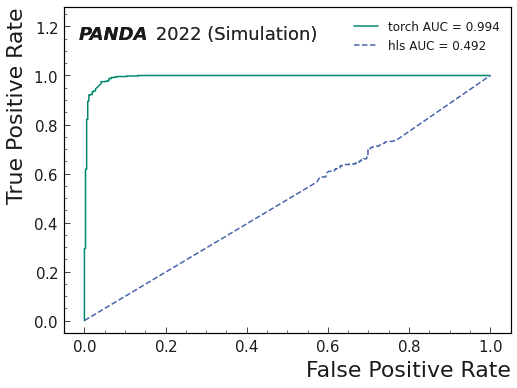

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from utils.plotting.plot import watermark

torch_roc = all_torch_error['ROC']
hls_roc = all_hls_error['ROC']

def plot_roc(roc, label):
    plt.style.use("kit")
    fpr, tpr, thresholds = roc
    auc_val=auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} AUC = {auc_val:.3f}', marker='None')
    
    watermark(py=0.9, shift=0.16, scale=1.1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.91), fontsize=12)
    
plot_roc(torch_roc, 'torch')    
plot_roc(hls_roc, 'hls')
plt.savefig('img/hls_roc_plot.png', bbox_inches='tight')
plt.show()



# Compare for different floating point sizes

In [6]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")  


bits = range(4,16)
rocs=[]

for b in tqdm(bits):
    precision = f'ap_fixed<{b},{int(b/2)}>'
    model_dir = 'models/trained_IN_neurons_8.pt'
    output_dir = f"hls_output/precision_{b}"
    index_precision = 'ap_uint<8>'
    reuse = 1
    part = 'xcvu9p-flga2104-2L-e'

    torch_model, hls_model, torch_wrapper = load_models(trained_model_dir, output_dir, n_neurons, precision, reuse, part,node_shape, edge_shape, hls_only=False)
    hls_model.compile()
    all_torch_error, all_hls_error, _, _ = compare_hls4ml(graphs, torch_model, hls_model, torch_wrapper)
    hls_roc = all_hls_error['ROC'] 
    rocs.append(hls_roc)

  0%|                                                                                                                           | 0/12 [00:00<?, ?it/s]

Writing HLS project
Done
Writing HLS project
Done


  8%|█████████▌                                                                                                         | 1/12 [00:09<01:42,  9.34s/it]

Writing HLS project
Done
Writing HLS project
Done


 17%|███████████████████▏                                                                                               | 2/12 [00:18<01:32,  9.23s/it]

Writing HLS project
Done
Writing HLS project
Done


 25%|████████████████████████████▊                                                                                      | 3/12 [00:27<01:22,  9.18s/it]

Writing HLS project
Done
Writing HLS project
Done


 33%|██████████████████████████████████████▎                                                                            | 4/12 [00:36<01:13,  9.22s/it]

Writing HLS project
Done
Writing HLS project
Done


 42%|███████████████████████████████████████████████▉                                                                   | 5/12 [00:45<01:03,  9.12s/it]

Writing HLS project
Done
Writing HLS project
Done


 50%|█████████████████████████████████████████████████████████▌                                                         | 6/12 [00:54<00:54,  9.10s/it]

Writing HLS project
Done
Writing HLS project
Done


 58%|███████████████████████████████████████████████████████████████████                                                | 7/12 [01:04<00:45,  9.11s/it]

Writing HLS project
Done
Writing HLS project
Done


 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 8/12 [01:13<00:36,  9.11s/it]

Writing HLS project
Done
Writing HLS project
Done


 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 9/12 [01:22<00:27,  9.10s/it]

Writing HLS project
Done
Writing HLS project
Done


 83%|███████████████████████████████████████████████████████████████████████████████████████████████                   | 10/12 [01:31<00:18,  9.10s/it]

Writing HLS project
Done
Writing HLS project
Done


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [01:40<00:09,  9.14s/it]

Writing HLS project
Done
Writing HLS project
Done


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:49<00:00,  9.14s/it]


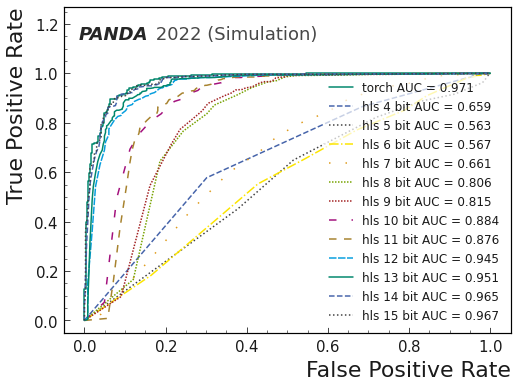

In [7]:
def plot_roc(roc, label):
    plt.style.use("kit")
    fpr, tpr, thresholds = roc
    auc_val=auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} AUC = {auc_val:.3f}', marker='None')
    
plot_roc(torch_roc, 'torch') 
for i,b in enumerate(bits):
    
    plot_roc(rocs[i], f'hls {b} bit')

watermark(py=0.9, shift=0.16, scale=1.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=12, frameon = True, framealpha = 0.7, facecolor = 'white', edgecolor = 'white')
plt.savefig('img/hls_roc_plot.png', bbox_inches='tight')
plt.show()

In [8]:
len(rocs)
bits

range(4, 16)

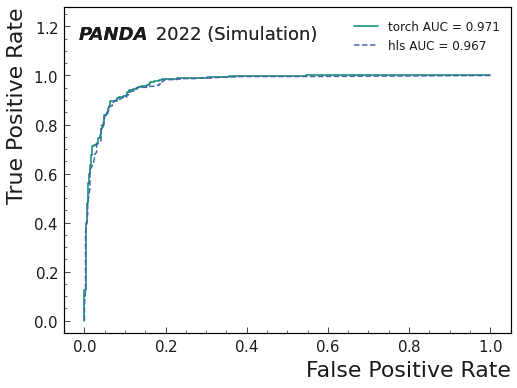

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from utils.plotting.plot import watermark

torch_roc = all_torch_error['ROC']
hls_roc = all_hls_error['ROC']

def plot_roc(roc, label):
    plt.style.use("kit")
    fpr, tpr, thresholds = roc
    auc_val=auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} AUC = {auc_val:.3f}', marker='None')
    
    watermark(py=0.9, shift=0.16, scale=1.1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.91), fontsize=12)
    
plot_roc(torch_roc, 'torch')    
plot_roc(hls_roc, 'hls')
plt.savefig('img/hls_roc_plot.png', bbox_inches='tight')
plt.show()

# Build HLS

In [10]:
hls4ml.report.read_vivado_report('hls_output/test/')

NameError: name 'hls4ml' is not defined